##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [12]:
# %pip install pandas 
# %pip install matplotlib
%pip install statsmodels
%pip install seaborn
%pip install scikit-learn
%pip install mlxtend
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 10.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 8.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [13]:
# Can have as many cells as you want for code
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


filepath = "./data/catA_train.csv" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [15]:
###...code...###
df = pd.read_csv(filepath)
df.head
df.shape

# check if global ultimate company = domestic ultimate company means domestic sale = global sale
a = df.loc[df['Global Ultimate Company'] == df['Domestic Ultimate Company']] 
b = a.loc[df['Sales (Domestic Ultimate Total USD)'] != df['Sales (Global Ultimate Total USD)']]

a.shape #(18566, 28) 
b.shape #(18545, 28)

df['Industry'].nunique() # too many industries 580
df['8-Digit SIC Description'].nunique() #2191
df['8-Digit SIC Code'].nunique() #2255
df['SIC Code'].nunique() #582
c = df.loc[df['SIC Code']>1799]
d = c.loc[c['SIC Code']<4000]


df.loc[df['Entity Type']=='Independent']
df.loc[df['Sales (Domestic Ultimate Total USD)'] > df['Sales (Global Ultimate Total USD)']] #2675

df.shape

29182 *  0.01487218



433.99995676000003

In [16]:
## replace the SIC Code with Sector name
new_df = df.copy()

new_df.loc[new_df['SIC Code'].between(100, 999), 'SIC Industry'] = 'Agriculture'

In [17]:
## Replace missing values in Year Found by the median 2008 

new_df['Year Found'].describe()

new_df['Year Found'] = new_df['Year Found'].fillna(2008)


new_df['Year Found'].describe()
df['Year Found'].describe()

len(df.loc[df['Year Found']==2008])
len(new_df.loc[new_df['Year Found']==2008])




1550

Axes(0.125,0.11;0.775x0.77)
                                     Year Found  \
Year Found                             1.000000   
Sales (Domestic Ultimate Total USD)    0.014523   

                                     Sales (Domestic Ultimate Total USD)  
Year Found                                                      0.014523  
Sales (Domestic Ultimate Total USD)                             1.000000  


,Employees (Domestic Ultimate Total),Employees (Single Site)
Employees (Domestic Ultimate Total),1.000000,0.139117
Employees (Single Site),0.139117,1.000000


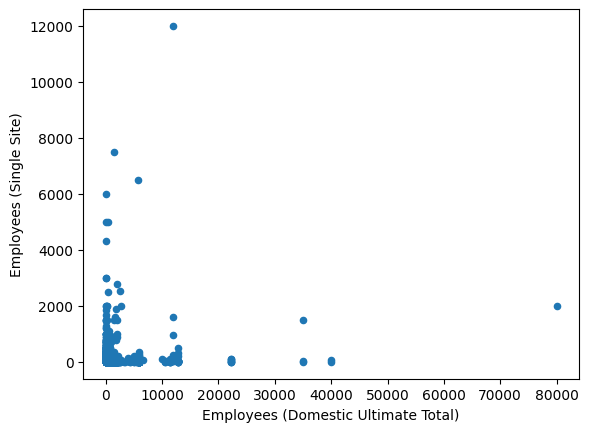

In [18]:
## Explore Employees (Domestic Ultimate Total)

new_df['Employees (Domestic Ultimate Total)'].describe() #mean = 139.764182
# new_df.loc[new_df['Employees (Domestic Ultimate Total)'] == 80000]

a = new_df[new_df['Employees (Domestic Ultimate Total)']<50000] ## remove the two rows where they have 80000 workers

a['Employees (Domestic Ultimate Total)'].describe() #mean = 134.275695

print(df.plot.scatter(x = 'Employees (Domestic Ultimate Total)', y = 'Employees (Single Site)'))

new_df.loc[new_df['Employees (Domestic Ultimate Total)'].isna()][['Employees (Single Site)','Employees (Domestic Ultimate Total)']]

print(df[['Year Found', 'Sales (Domestic Ultimate Total USD)']].corr())

df[['Employees (Domestic Ultimate Total)', 'Employees (Single Site)']].corr()

In [19]:
## Run OLS on Employees (Domestic Ultimate Total) using Emplyees (Single Site)
result = sm.ols(formula="df['Employees (Domestic Ultimate Total)'] ~ df['Employees (Single Site)']", data=df).fit()
print(result.summary())

# the result is significant, so can replace missing values with Employees (Single Site)
new_df['Employees (Domestic Ultimate Total)']= new_df['Employees (Domestic Ultimate Total)'].fillna(new_df['Employees (Single Site)'])

# only five rows where we cannot replace with Employees (Single Site) -> remove these rows? 
new_df.loc[new_df['Employees (Domestic Ultimate Total)'].isna()][['Employees (Single Site)','Employees (Domestic Ultimate Total)']]  


                                        OLS Regression Results                                       
Dep. Variable:     df['Employees (Domestic Ultimate Total)']   R-squared:                       0.019
Model:                                                   OLS   Adj. R-squared:                  0.019
Method:                                        Least Squares   F-statistic:                     329.6
Date:                                       Sun, 28 Jan 2024   Prob (F-statistic):           5.79e-73
Time:                                               20:35:21   Log-Likelihood:            -1.4246e+05
No. Observations:                                      16705   AIC:                         2.849e+05
Df Residuals:                                          16703   BIC:                         2.849e+05
Df Model:                                                  1                                         
Covariance Type:                                   nonrobust                      

,Employees (Single Site),Employees (Domestic Ultimate Total)
7727,NaN,NaN
10768,NaN,NaN
16455,NaN,NaN
20822,NaN,NaN
22660,NaN,NaN


In [20]:
# convert SIC Code into Industrys and add a new column to the new_df
industry_mapping = {
    (101, 999): 'Agriculture',
    (1002, 1499): 'Mining',
    (1500, 1799): 'Construction',
    (2000, 3999): 'Manufacturing',
    (4000, 4999): 'Transportation',
    (5000, 5199): 'Wholesales',
    (5200, 5999): 'Retail',
    (6000, 6799): 'Finance',
    (7000, 8999): 'Services',
    (9000, 9899): 'Public',
    (9900, 10000): 'Others'
}
def map_to_industry(sic_code):
    for code_range, industry in industry_mapping.items():
        if code_range[0] < sic_code <= code_range[1]:
            return industry
    return 'Other'

# Create a new column 'Industry' based on the mapping
new_df['Industrys'] = new_df['SIC Code'].map(map_to_industry)

,Import/Export Status,Sales (Domestic Ultimate Total USD)
Import/Export Status,1.000000,-0.005679
Sales (Domestic Ultimate Total USD),-0.005679,1.000000


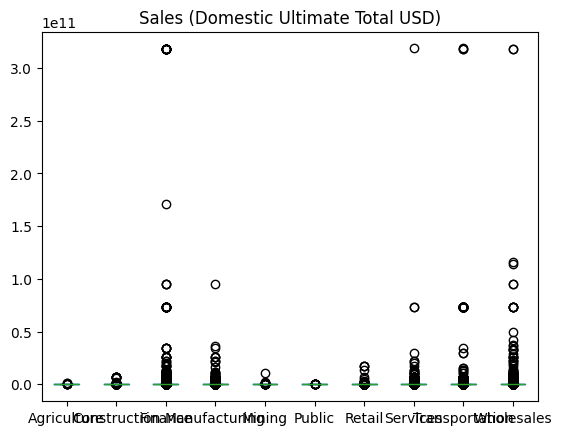

In [21]:
# barplot of sales(domestic) vs industrys
new_df.plot.box(by = 'Industrys',column = 'Sales (Domestic Ultimate Total USD)')
#test correlation between 'import/export status' and 'sales (domestic ultimate total)'
df_import = new_df.copy()

# Simple assumption that BLANK in import/export means NEITHER
#if import/export status is NaN replace with 0, otherwise 1
df_import['Import/Export Status']=df_import['Import/Export Status'].fillna(0).map(lambda x:0 if x==0 else 1)
df_import[['Import/Export Status','Sales (Domestic Ultimate Total USD)']].corr()


# To do 
# MAKE BARPLOT OF SALES AGAINST IMPORT, EXPORT, IMPORT/EXPORT, and NAN 


In [22]:

variables_to_remove = [
    'LATITUDE', 'LONGITUDE', 'AccountID', 'Company', '8-Digit SIC Code',
    'Parent Country', 'Import/Export Status', 'Domestic Ultimate Company',
    '8-Digit SIC Description', 'Company Description', 'Company Status (Active/Inactive)',
    'Fiscal Year End', 'Is Global Ultimate', 'Global Ultimate Company',
    'Global Ultimate Country','SIC Industry','Parent Company', 'SIC Code', 'Industry', 'Square Footage', 'Employees (Single Site)', 'Sales (Global Ultimate Total USD)', 'Employees (Global Ultimate Total)'
]
df = new_df.drop(variables_to_remove, axis=1)
df.head()
# df.describe()
#df.info()

,Year Found,Entity Type,Ownership Type,Employees (Domestic Ultimate Total),Sales (Domestic Ultimate Total USD),Is Domestic Ultimate,Industrys
0,2020.0,Subsidiary,Private,25.0,2.209224e+06,0.0,Services
1,2015.0,Subsidiary,Private,100.0,7.093536e+09,0.0,Transportation
2,1993.0,Subsidiary,Private,4.0,1.026308e+06,1.0,Finance
3,2006.0,Subsidiary,Private,100.0,7.339898e+10,0.0,Finance
4,2006.0,Parent,Private,4.0,4.322130e+05,1.0,Finance


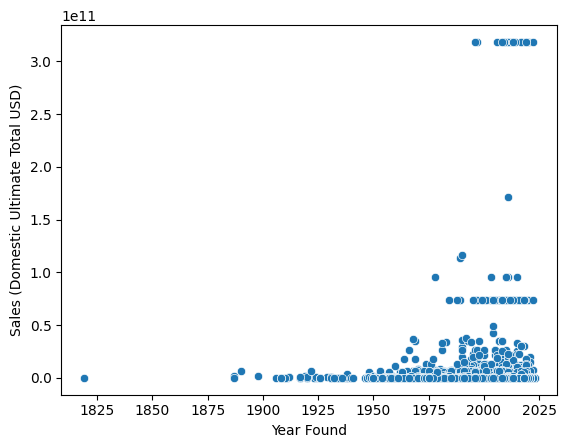

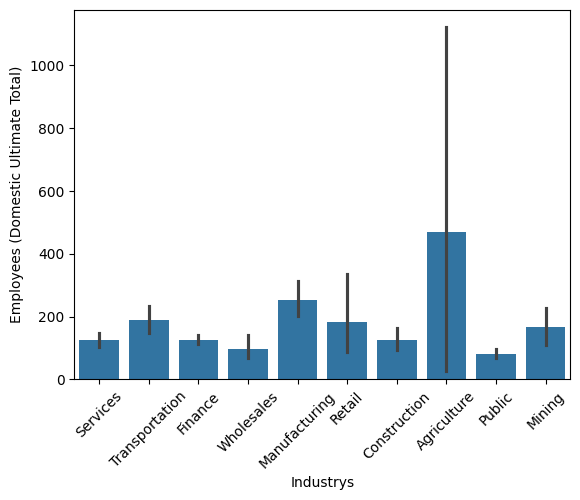

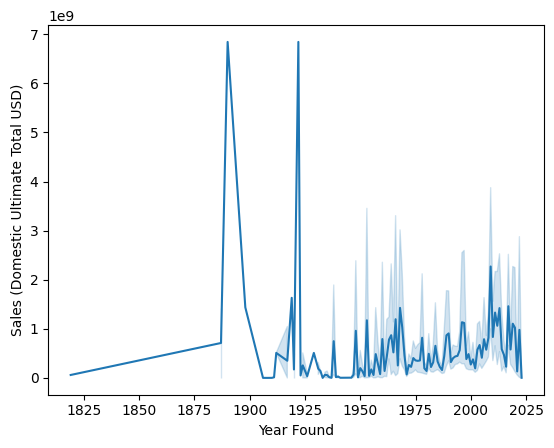

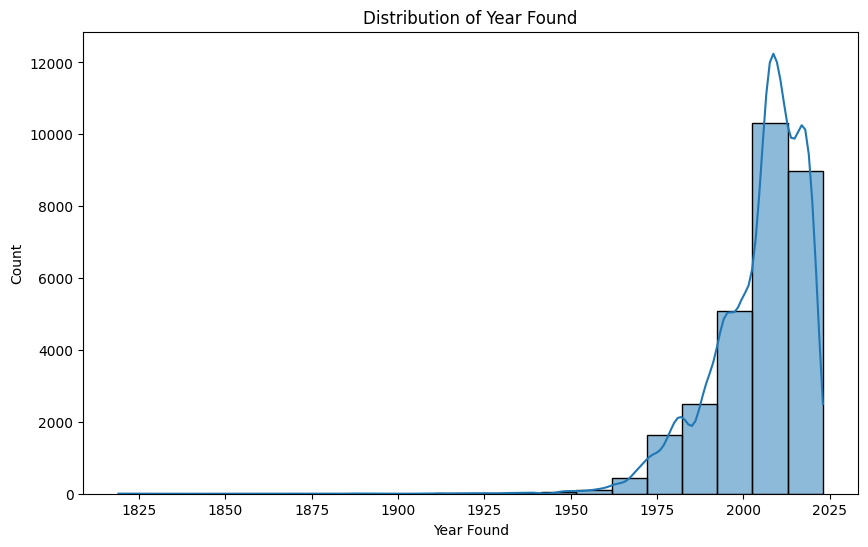

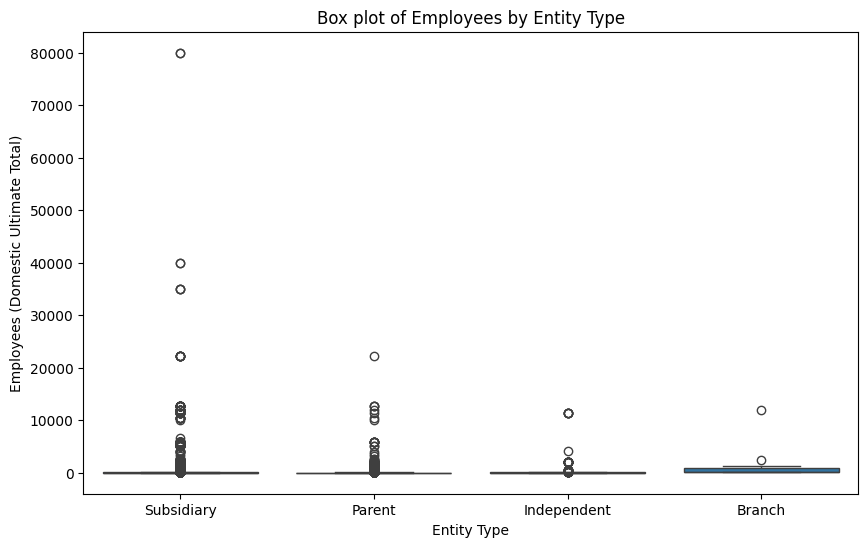

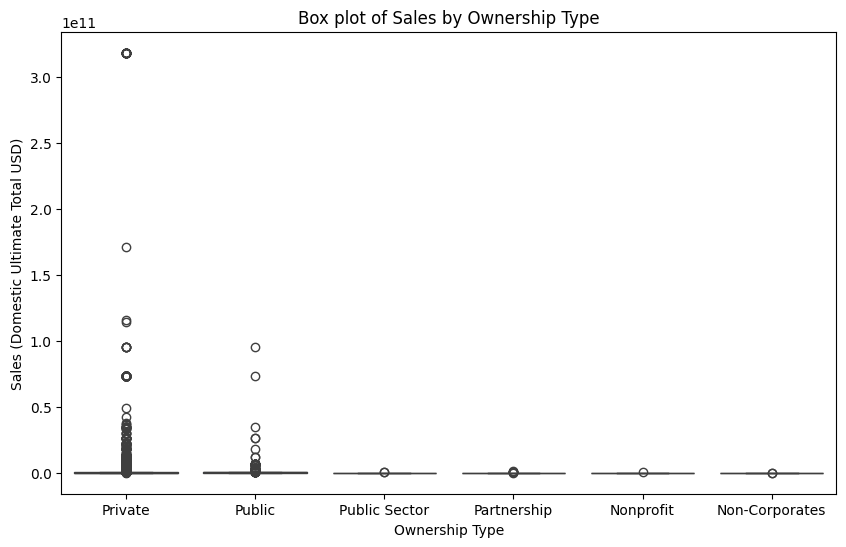

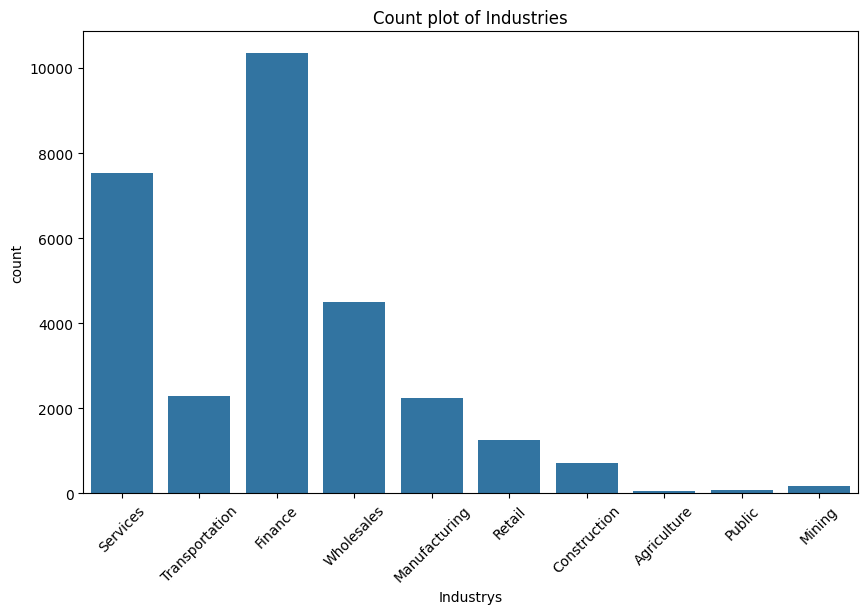

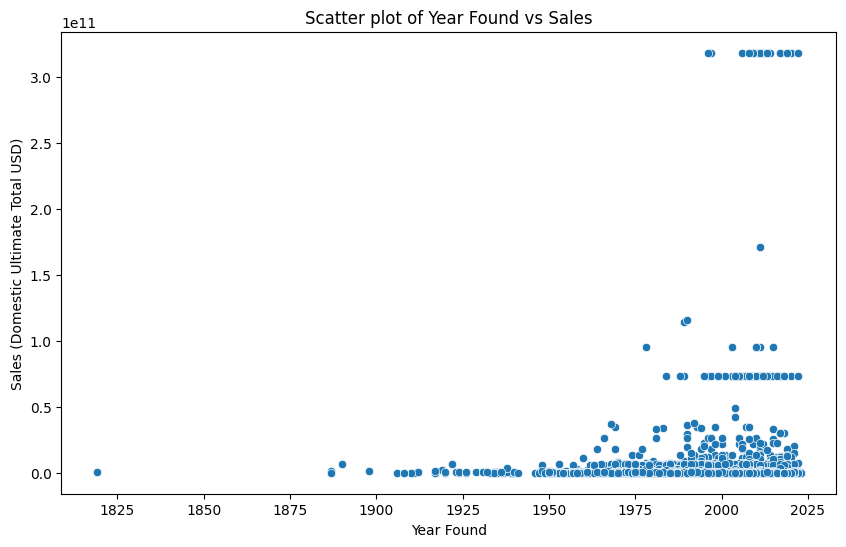

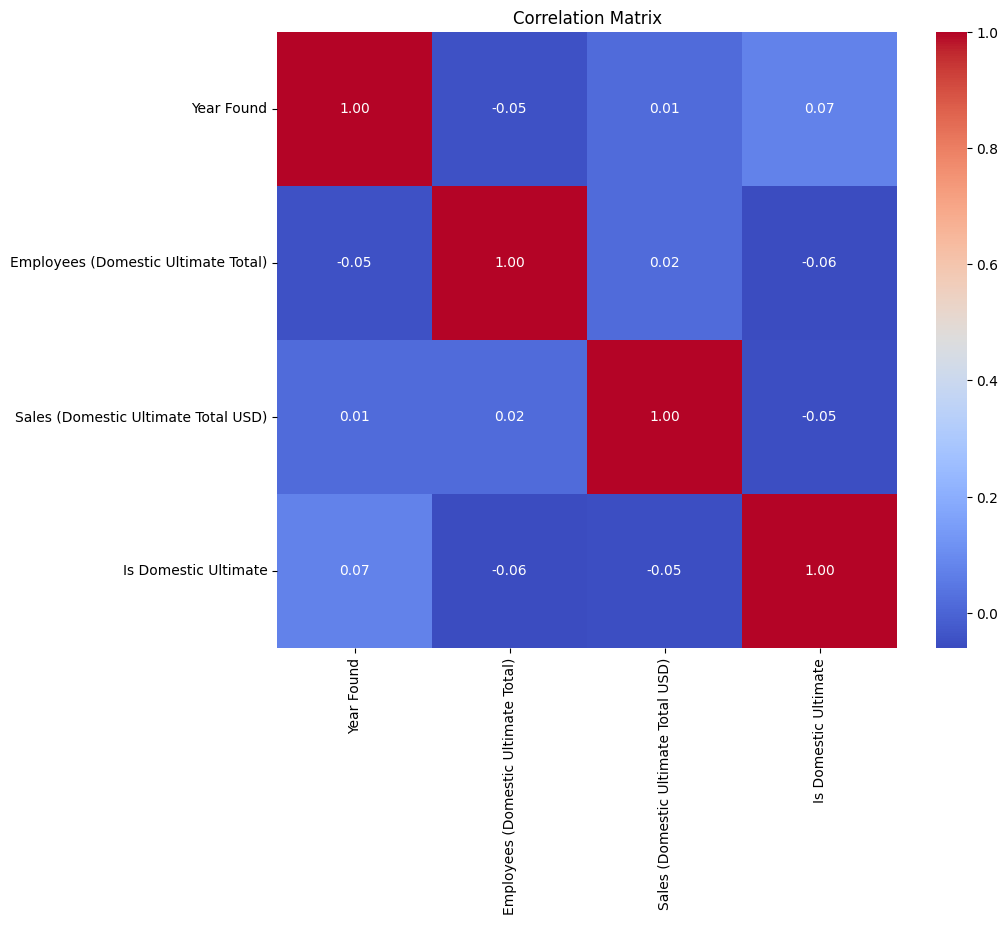

In [28]:
#To do -> look at the error in plots 

variables = df.columns

# Creating scatter plots
# for i in range(len(variables)):
#     for j in range(i + 1, len(variables)):
#         try:
#             plt.scatter(df[variables[i]], df[variables[j]])
#             plt.title(f'{variables[i]} vs {variables[j]}')
#             plt.xlabel(variables[i])
#             plt.ylabel(variables[j])
#             plt.show()
#         except Exception as e:
#             print(f"Error plotting {variables[i]} vs {variables[j]}: {e}")

sns.scatterplot(x='Year Found', y='Sales (Domestic Ultimate Total USD)', data=df)
plt.show()

# Grouped Analysis
sns.barplot(x='Industrys', y='Employees (Domestic Ultimate Total)', data=df)
plt.xticks(rotation=45)
plt.show()

# Time Series Analysis
sns.lineplot(x='Year Found', y='Sales (Domestic Ultimate Total USD)', data=df)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['Year Found'], bins=20, kde=True)
plt.title('Distribution of Year Found')
plt.show()

# # Explore the distribution of 'Employees'
# plt.figure(figsize=(10, 6))
# sns.histplot(df['Employees (Domestic Ultimate Total)'], bins=20, kde=True)
# plt.title('Distribution of Employees')
# plt.show()

# # Explore the distribution of 'Sales'
# plt.figure(figsize=(10, 6))
# sns.histplot(df['Sales (Domestic Ultimate Total USD)'], bins=20, kde=True)
# plt.title('Distribution of Sales')
# plt.show()

# Box plot for 'Employees' by 'Entity Type'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Entity Type', y='Employees (Domestic Ultimate Total)', data=df)
plt.title('Box plot of Employees by Entity Type')
plt.show()

# Box plot for 'Sales' by 'Ownership Type'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Ownership Type', y='Sales (Domestic Ultimate Total USD)', data=df)
plt.title('Box plot of Sales by Ownership Type')
plt.show()

# Count plot for 'Industrys'
plt.figure(figsize=(10, 6))
sns.countplot(x='Industrys', data=df)
plt.title('Count plot of Industries')
plt.xticks(rotation=45)
plt.show()

# Scatter plot for 'Year Found' vs 'Sales'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year Found', y='Sales (Domestic Ultimate Total USD)', data=df)
plt.title('Scatter plot of Year Found vs Sales')
plt.show()

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numeric_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

MODEL SELECTION



In [ ]:
from sklearn.decomposition import PCA

                                          PC0       PC1       PC2       PC3  \
Year Found                           0.093890 -0.248156  0.159316 -0.175703   
Employees (Domestic Ultimate Total) -0.037153  0.062373 -0.060926 -0.037325   
Is Domestic Ultimate                 0.376136 -0.146002  0.050263  0.370566   
Construction                        -0.042846  0.011301 -0.022232  0.015119   
Finance                              0.262667  0.015373 -0.082713 -0.686470   
Manufacturing                       -0.057044  0.059966 -0.078498  0.127750   
Mining                              -0.013135 -0.004766  0.002044  0.004644   
Public                              -0.013758  0.284768  0.631457 -0.042565   
Retail                              -0.069000  0.001652 -0.011820 -0.052692   
Services                            -0.061575 -0.093514  0.135228  0.416667   
Transportation                      -0.104932  0.009869 -0.024165 -0.021104   
Wholesales                          -0.090642 -0.003

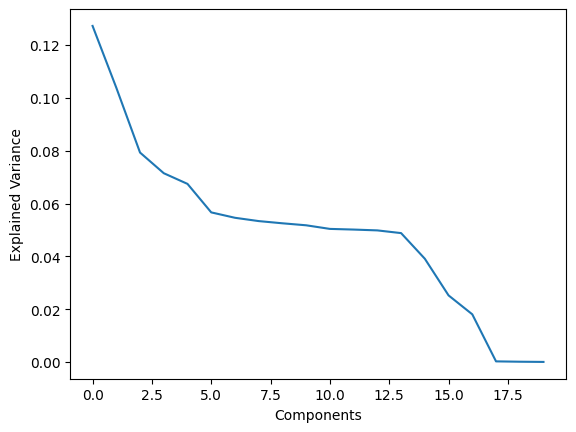

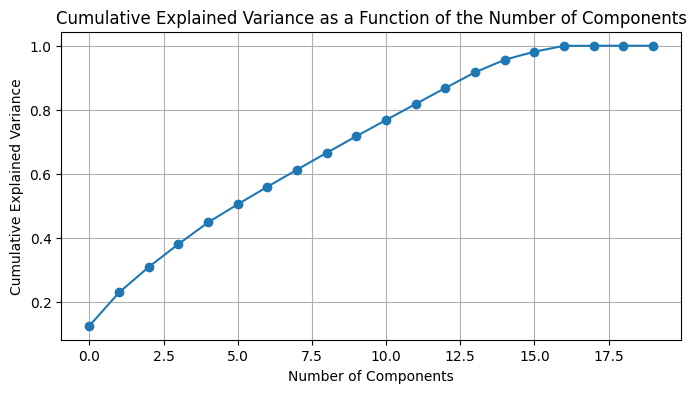

In [ ]:
df_copy = df.copy()

df_copy = df_copy.drop(['Sales (Domestic Ultimate Total USD)'],axis=1)

#df=df.join(pd.get_dummies(df.Industrys))
df_copy=pd.get_dummies(df_copy, columns=['Industrys'],drop_first=True)
df_copy=pd.get_dummies(df_copy, columns=['Entity Type'],drop_first=True)
df_copy=pd.get_dummies(df_copy, columns=['Ownership Type'],drop_first=True)

df_copy.columns = df_copy.columns.str.replace('Industrys_', '')
df_copy.columns = df_copy.columns.str.replace('Entity Type_', '')
df_copy.columns = df_copy.columns.str.replace('Ownership Type_', '')
df_copy = df_copy.dropna()

df_normalized=(df_copy - df_copy.mean()) / df_copy.std()
pca = PCA(n_components=df_copy.shape[1])
#pca.fit(df_normalized)
pca.fit(df_normalized)


loadings = pd.DataFrame(pca.components_.T, columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],index=df_normalized.columns)
print(loadings)

plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

# Calculate the cumulative variance explained by each component
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

print(df.head())
# Assuming df_copy is your DataFrame and 'Sales (Total Domestic USD)' is your target variable
X = df_copy
y = df.dropna()['Sales (Domestic Ultimate Total USD)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (if not already done)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
# Select the number of components based on cumulative variance plot
n_components = 13
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Regression Model
regressor = LinearRegression()
regressor.fit(X_train_pca, y_train)

# Predictions
y_pred = regressor.predict(X_test_pca)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


   Year Found Entity Type Ownership Type  Employees (Domestic Ultimate Total)  \
0      2020.0  Subsidiary        Private                                 25.0   
1      2015.0  Subsidiary        Private                                100.0   
2      1993.0  Subsidiary        Private                                  4.0   
3      2006.0  Subsidiary        Private                                100.0   
4      2006.0      Parent        Private                                  4.0   

   Sales (Domestic Ultimate Total USD)  Is Domestic Ultimate       Industrys  
0                         2.209224e+06                   0.0        Services  
1                         7.093536e+09                   0.0  Transportation  
2                         1.026308e+06                   1.0         Finance  
3                         7.339898e+10                   0.0         Finance  
4                         4.322130e+05                   1.0         Finance  
Mean Squared Error: 5.797163413955601e+

FEATURE SELECTION (STEPWISE)

In [ ]:
df_copy2 = df_copy

# Define your predictors and response variable
X = df_copy2[['Year Found', 'Employees (Domestic Ultimate Total)']]
y = df_copy2['Sales (Domestic Ultimate Total USD)']
df_copy2 = df_copy2.dropna()

print(X)
# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Initialize Linear Regression model
lr = LinearRegression()

# Initialize SequentialFeatureSelector
sfs = SFS(lr, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=5)

# Perform SFS
sfs = sfs.fit(X_train, y_train)

# Print the selected feature indices and names
selected_features_indices = sfs.k_feature_idx_
selected_features_names = X.columns[list(selected_features_indices)]

print('Selected features indices:', selected_features_indices)
print('Selected features names:', selected_features_names)

       Year Found  Employees (Domestic Ultimate Total)
0          2020.0                                 25.0
1          2015.0                                100.0
2          1993.0                                  4.0
3          2006.0                                100.0
4          2006.0                                  4.0
...           ...                                  ...
29177      2009.0                                 50.0
29178      2008.0                                  4.0
29179      1991.0                                  5.0
29180      2018.0                                  4.0
29181      2018.0                                  4.0

[29177 rows x 2 columns]
Selected features indices: (0, 1)
Selected features names: Index(['Year Found', 'Employees (Domestic Ultimate Total)'], dtype='object')


c:\Users\tansi\miniconda3\envs\SDSDatathon\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\tansi\miniconda3\envs\SDSDatathon\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\tansi\miniconda3\envs\SDSDatathon\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''

    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!